In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
def place_fesc(fesc_arr, threshold=1e-3):
    frac_small = (fesc_arr < threshold).sum()/len(fesc_arr)
    
    fesc_new = np.zeros_like(fesc_arr)
    for i, fesc in enumerate(fesc_arr):
        if fesc < threshold:
            fesc_new[i] = 1.5*threshold+np.random.uniform(-0.5*threshold, 0.5*threshold) 
        else:
            fesc_new[i] = fesc
    return frac_small, fesc_new

In [3]:
def get_scatter(df, prop, x_prop='StarMass', bin_width=0.1, mode='median', threshhold=1e-3, relative=False):
    
    f_esc = df.loc[:,'f_esc']
    x_values = df.loc[:,x_prop]
    if bin_width==None:
        prop_norm = {}

        prop_norm[prop]=[]
        column = df[prop]
        if mode == 'median':
            norm_val = column.median()
        elif mode == 'mean':
            norm_val = column.mean()
        if relative:
            new_data=column/norm_val
        else:
            new_data=column-norm_val
        prop_norm[prop].extend(new_data)
        prop_norm[prop] = np.array(prop_norm[prop])
        return x_values, f_esc, prop_norm
        
    
    x_values_log = np.log10(x_values)
    log_edges = np.arange(x_values_log.min(), x_values_log.max(), bin_width)
    edges = np.power(10, log_edges)
    prop_norm = {}
    prop_norm[prop]=np.zeros(df[x_prop].size, dtype='float32')
    start_index = 0
    end_index = 0
    for i in range(len(edges)-1):
        column = df[(edges[i]*(1-1e-10)<df[x_prop]) & (df[x_prop]<edges[i+1])][prop]
        end_index += len(column)
        if mode == 'median':
            norm_val=column.median()
        elif mode == 'mean':
            norm_val=column.mean()
        if relative:
            #print(norm_val)
            new_data=column/norm_val
        else:
            new_data=column-norm_val

        prop_norm[prop][start_index:end_index] = new_data
        start_index=end_index
    prop_norm[prop] = np.array(prop_norm[prop])
    return x_values, f_esc, prop_norm

In [4]:
def plot_scatter_color(df, prop, x_prop='StarMass', bin_width=0.1, mode='median', threshold=1e-3, label=None, relative=False, log=False, save = False):
        
    x_labelsize = 50
    y_labelsize = 50

    length_major_ticks = 16
    length_minor_ticks = 8
    width_minor_ticks = 3
    width_major_ticks = 4
    labelsize_x_ticks = 35
    labelsize_y_ticks = 35
    
    marker_size = 45
    colorbar_labelsize = 50
    colorbar_ticklabelsize = 35
    
    axes_width = 3
    
    figure_width = 20
    figure_height = 20
    
    if relative:
        v_min=0.5
        v_max=2.0
#         v_min = 0.8
#         v_max = 1.2
        v_center=1.0
    else:
        v_min=None
        v_max=None
        v_center=None
    
    if log:
        v_min=-0.3
        v_max=0
        v_center=0.3
    
    if x_prop == 'HaloMass':
        mult = 1e10
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif x_prop == 'StarMass':
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
    

    df.sort_values(by=x_prop, inplace=True)
    x_values, f_esc, prop_norm = get_scatter(df, prop=prop, x_prop=x_prop, bin_width=bin_width, mode=mode, threshhold=threshold, relative=relative)
    
    y_axis = 'f_esc' 
    y_label = '$f_\mathrm{esc}$'

    frac_small, f_esc_plot = place_fesc(f_esc, threshold)
    
    f, ax = plt.subplots()
    
    if log:
        color_data = np.log10(prop_norm[prop])
        if label == None:
            bar_label = f'$\log(\Delta ${prop})'
        else:
            bar_label = label
    else:
        color_data = prop_norm[prop]
        if label == None:
            bar_label = f'$\Delta ${prop}'
        else: 
            bar_label = label

    col_norm = colors.DivergingNorm(vmin=v_min, vcenter=v_center, vmax=v_max)
    subfig = ax.scatter(np.log10(x_values), f_esc_plot, c=color_data, norm=col_norm, cmap=plt.get_cmap('coolwarm'), zorder=-20, s=marker_size)
    ax.set_yscale('log')
    ax.set_ylim(threshold,1.)
    ax.set_xlabel(x_label, size=x_labelsize)
    ax.set_ylabel(y_label, size=y_labelsize)
    
    # Save the scatter as a rasterization graphic to make the plots smaller
    ax.set_rasterization_zorder(-15)

    ax.tick_params(length=length_major_ticks, width=width_major_ticks)
    ax.tick_params(length=length_minor_ticks, width=width_minor_ticks, which='minor')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = f.colorbar(subfig, cax=cax)
    cbar.set_label(bar_label, size=colorbar_labelsize)
    cbar.ax.tick_params(labelsize=colorbar_ticklabelsize)

    xticklabels = ax.get_xticklabels()
    plt.setp(xticklabels, visible=True)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=labelsize_x_ticks) 
    plt.rc('ytick', labelsize=labelsize_y_ticks) 
    
    plt.rcParams["figure.figsize"] = (figure_width,figure_height)
    plt.tight_layout(rect=(0,0,1,0.7))
    
    if save:
        if bin_width==None:
            filename = f'/u/ivkos/analysis/plots/{x_prop}_scatter_{prop}_nobinning.pdf'
        else:
            filename = f'/u/ivkos/analysis/plots/scatter_plots/{prop}_scatter.pdf'
        plt.savefig(filename, bbox_inches = 'tight')
    plt.show();
    return

In [5]:
def lum_str_to_float(string):
    string = string.replace('d', 'e')
    return float(string)

In [6]:
def source_dist_lum(ID, redshift, conf, side_length, r_v):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    dist = np.sqrt(np.sum(coord**2, axis=1))*2/side_length

    dist_lum_df = pd.DataFrame({'dist':dist,'lum':lum[3]})
    dist_lum_df.sort_values('dist', inplace=True)

    return dist_lum_df

In [7]:
def mass_dens_r(dist_lum_df, frac, r_v):
    lum = np.vectorize(lum_str_to_float)(dist_lum_df['lum'])
    sorted_dist = np.array(dist_lum_df['dist'])
    frac_lum = frac*lum.sum()
    
    radius_idx = 0
    tot_lum = 0.
    while tot_lum <= frac_lum:
        prev_lum = tot_lum
        tot_lum += lum[radius_idx]
        radius_idx += 1
        
    contribution_idx1 = (tot_lum-frac_lum)/(tot_lum-prev_lum)
    contribution_idx2 = 1-contribution_idx1
    
    r_frac = contribution_idx1*sorted_dist[radius_idx-2]+contribution_idx2*sorted_dist[radius_idx-1]
    return r_frac

In [8]:
def update_mass_rad(df, frac, conf):
    radii = []
    new_column_name = f'r_mass_{int(frac*100)}'
    for index, row in df.iterrows():
        dist_lum_df = source_dist_lum(ID=row.ID, redshift=row.z, conf=conf, side_length=row.GridSize, r_v=row.HaloRadii)
        r_frac = mass_dens_r(dist_lum_df=dist_lum_df, frac=frac, r_v=row.HaloRadii)
        radii.append(r_frac)
    df[new_column_name] = radii

In [9]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

In [10]:
h=0.6774
def update_df(df):
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['avg_dens']=df['HaloMass']*3/(df['HaloRadii']**3*4*np.pi)
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    df['SFR/StarMass']= df['SFR']*df['StarMass']/1e4
    df['M_star_M_gas'] = df['FractionStars']/df['FractionGas']
    df['M_dust_M_gas'] = df['DustMass']/df['GasMassGrid']
    return

In [11]:
def add_relative_mass_r(df, mass_r_frac):
    df[f'R_M,{int(frac*100)}']=df['HaloRadii']/df[f'r_mass_{int(frac*100)}']
    df['avg_halo_dens'] = 3*df['HaloMass']/(4*np.pi*df['HaloRadii']**3)
    return

In [12]:
df = pd.read_pickle('dfs/full_esc_updated.pickle')
frac = 0.5
update_mass_rad(df, frac,'full_esc')
# update_df(df)
# add_relative_mass_r(df, frac)

In [13]:
update_df(df)

In [18]:
props = [ 'HaloRadii', 'HaloMass', 'clumping', 'Q0','avg_dens', 'r_mass_50', 'avg_halo_dens',
         'Metallicity','FractionGas', 'FractionDust', 'clump_gas', 'sigma_gas_gal', 'sigma_star_gal', 'SFR'
        ]

In [19]:
prop_label = {
    'clumping':r'$C_\mathrm{halo}$', 
    'Q0':r'$Q_0$', 
    'HaloRadii':r'$R_\mathrm{vir}$', 
    'HaloMass':r'$M_\mathrm{vir}$', 
    'avg_dens':r'$\bar{\rho}$', 
    'avg_halo_dens':r'$\bar{\rho}$',
    'r_mass_50':r'$R_{\frac{1}{2}\mathrm{star}}$',
    'Metallicity':r'$Z$',
    'FractionGas':r'$f_\mathrm{gas}$', 
    'FractionDust':r'$f_\mathrm{dust}$', 
    'clump_gas':r'$C_\mathrm{galaxy}$', 
    'sigma_gas_gal':r'$\Sigma_\mathrm{gas}$', 
    'sigma_star_gal':r'$\Sigma_\mathrm{star}$', 
    'SFR':'SFR',
    'M_star_M_gas':r'$M_\mathrm{star}/M_\mathrm{gas}$',
    'M_dust_M_gas':r'$M_\mathrm{dust}/M_\mathrm{gas}$'
}

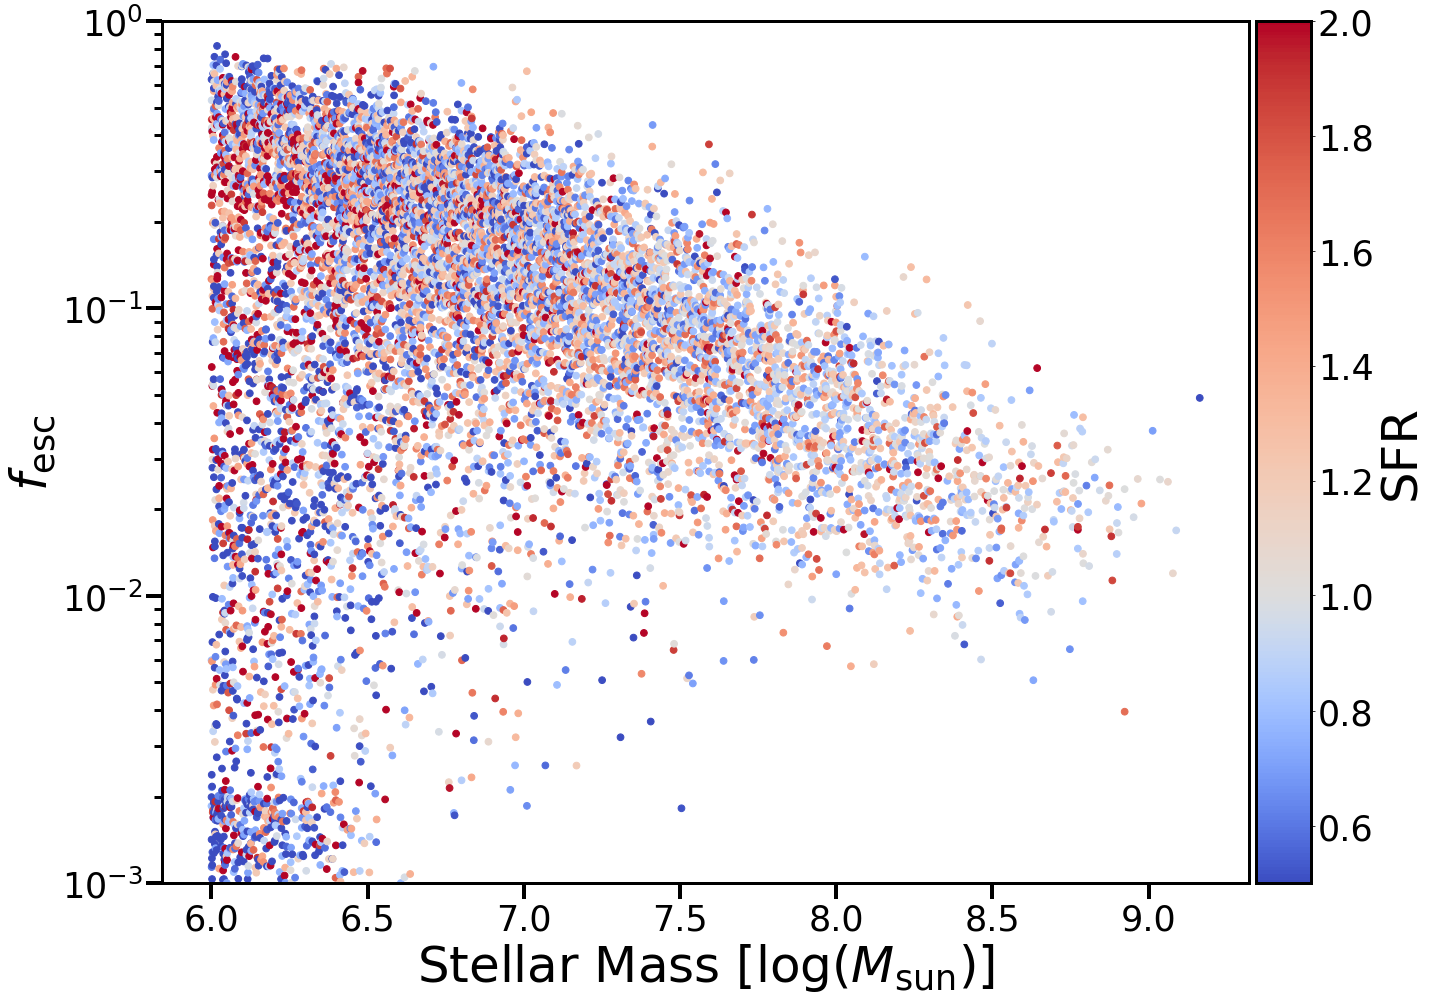

In [34]:
#for prop in props:
prop = 'SFR'
plot_scatter_color(df, prop=prop, x_prop='StarMass', bin_width=0.1, 
                   mode='median', threshold=1e-3, label=prop_label[prop], relative=True, log=False, save=True)

In [35]:
def calculate_averages(sub_df, prop, mode='mean', bins=30, log=False):

    if log:
        x_values = np.log10(sub_df[prop])
        bin_width = (x_values.max()-x_values.min())/bins
    else:
        x_values = sub_df[prop]
        bin_width = (x_values.max()-x_values.min())/bins
    edges = np.arange(x_values.min(), x_values.max(), bin_width)
    if log:
        edges = np.power(10, edges)
        
    centers = []
    fesc_values = []
    for i in range(len(edges)-1):
        fesc_subset = sub_df[(edges[i]*(1-1e-10)<sub_df[prop]) & (sub_df[prop]<edges[i+1])]['f_esc']
        centers.append((edges[i+1]+edges[i])/2)
        if mode == 'median':
            fesc_value=fesc_subset.median()
        elif mode == 'mean':
            fesc_value=fesc_subset.mean()
        fesc_values.append(fesc_value)
    return centers, fesc_values

In [36]:
def plot_inverted_color(df, prop, x_prop='StarMass', mass_bins=5, bins=30, mode='mean', threshold=1e-3, upper_ylim=1.0,
                        xlim_low=None, xlim_high=None,label=None, plot_average=False, log=False, save=False):
        
    x_labelsize = 50
    y_labelsize = 50

    length_major_ticks = 16
    length_minor_ticks = 8
    width_minor_ticks = 3
    width_major_ticks = 4
    labelsize_x_ticks = 35
    labelsize_y_ticks = 35
    
    marker_size = 45
    colorbar_labelsize = 50
    colorbar_ticklabelsize = 35
    legendsize = 40
    linewidth = 4
    axes_width = 3
    
    figure_width = 20
    figure_height = 20
    
    
    df.sort_values(by=x_prop, inplace=True)

    y_axis = 'f_esc' 
    y_label = '$f_\mathrm{esc}$'
    x_label = label
    if log:
        x_label = 'log('+label+')'
    
    x_values = df.loc[:,x_prop]
    x_values_log = np.log10(x_values)
    bin_width = (x_values_log.max()-x_values_log.min())/mass_bins
    log_edges = np.arange(x_values_log.min(), x_values_log.max()*1.001, bin_width)
    edges = np.power(10, log_edges)
    f, ax = plt.subplots()
    for i in range(len(edges)-1):
        bin_label = '$\log(M_\mathrm{star})=$'+'{:.2f}'.format(log_edges[i])+'-'+'{:.2f}'.format(log_edges[i+1])
        sub_df = df[(edges[i]*(1-1e-10)<df[x_prop]) & (df[x_prop]<edges[i+1])]
        frac_small, f_esc_plot = place_fesc(sub_df['f_esc'], threshold)
        centers, values = calculate_averages(sub_df=sub_df, prop=prop,  mode=mode, bins=bins, log=log)
        if plot_average:
            if log:
                subfig = ax.plot(np.log10(centers), values, label=bin_label, linewidth=linewidth)
            else:
                subfig = ax.plot(centers, values, label=bin_label, linewidth=linewidth)
        else:
            subfig = ax.scatter(sub_df[prop], f_esc_plot, zorder=-20, s=marker_size)

    
    ax.set_yscale('log')
    if xlim_low != None:
        ax.set_xlim(xlim_low, xlim_high)
    if log:
        ax.set_xscale('log')
    ax.set_ylim(threshold, upper_ylim)
    ax.set_xlabel(x_label, size=x_labelsize)
    ax.set_ylabel(y_label, size=y_labelsize)
    
    # Save the scatter as a rasterization graphic to make the plots smaller
    ax.set_rasterization_zorder(-15)

    ax.tick_params(length=length_major_ticks, width=width_major_ticks)
    ax.tick_params(length=length_minor_ticks, width=width_minor_ticks, which='minor')

    xticklabels = ax.get_xticklabels()
    plt.setp(xticklabels, visible=True)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=labelsize_x_ticks) 
    plt.rc('ytick', labelsize=labelsize_y_ticks) 
    
    plt.rcParams["figure.figsize"] = (figure_width,figure_height)
    plt.tight_layout(rect=(0,0,1,0.7))
    plt.legend(fontsize=legendsize)
    
    if save:
        filename = f'/u/ivkos/analysis/plots/scatter_plots/{prop}_line.pdf'
        plt.savefig(filename, bbox_inches = 'tight')
    plt.show();
    return

In [37]:
props = [ 'HaloRadii', 'HaloMass', 'clumping', 'Q0','avg_dens', 'r_mass_50', 'avg_halo_dens',
         'Metallicity','FractionGas', 'FractionDust', 'clump_gas', 'sigma_gas_gal', 'sigma_star_gal', 'SFR'
        ]

In [65]:
df['SFR'].describe()

count    9552.000000
mean        0.171328
std         0.454779
min         0.000000
25%         0.010560
50%         0.033442
75%         0.129781
max         7.494850
Name: SFR, dtype: float64

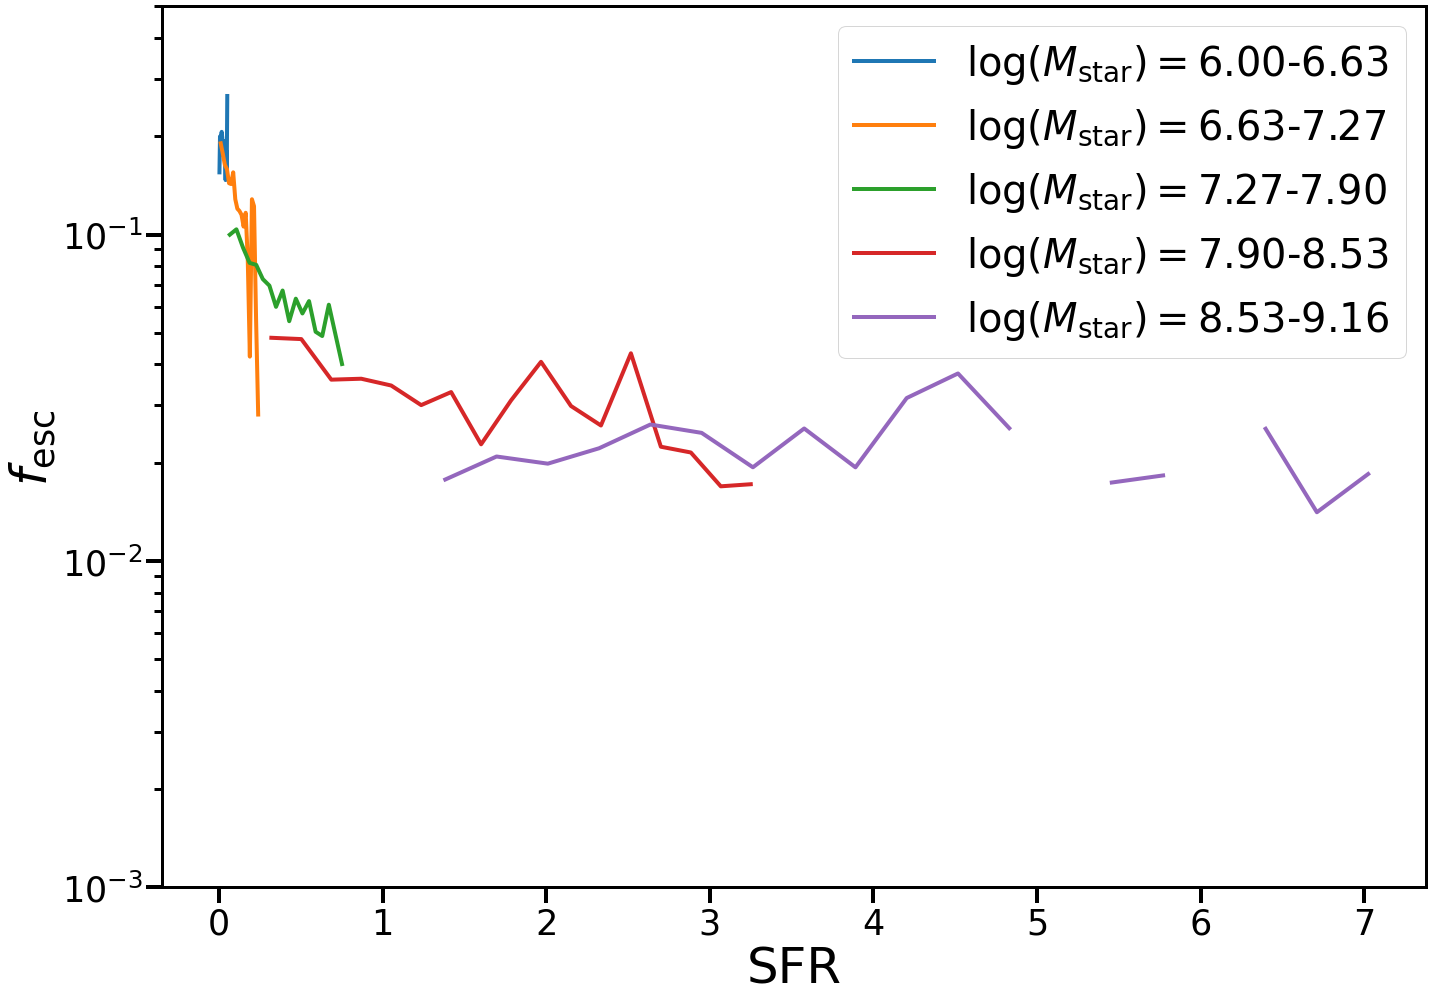

In [63]:
prop = 'SFR'
plot_inverted_color(df, prop=prop, x_prop='StarMass', mass_bins=5, bins=20, xlim_low=None, xlim_high=None,
                   mode='mean', threshold=1e-3, upper_ylim=0.5, label=prop_label[prop], plot_average=True, log=False, save=True)